# Poisson vs. gaussian regression
> How do the two models compare in terms of accuracy at different read counts?

In [2]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from aptr.simulation_new import make_tables
from aptr.database import RnaDB
from aptr.torch_solver import TorchSolver

plt.rc('font', size=20)

In [4]:
rnadb = RnaDB(
    # path_to_dnaA = "../../data/allDnaA.tsv",
    # path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [5]:
# Copied from scaling_experiment_matrix.ipynb

def score(solver, true_abundances, true_log2_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.B_hat.exp2().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp2(true_log2_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances


In [6]:
results = pd.DataFrame()
losses = [torch.nn.MSELoss(), torch.nn.PoissonNLLLoss(log_input=False)]
for multiplier in range(-3, 3):
    scale = 10**multiplier
    print(scale)
    abundances, log2_ptrs, otus = make_tables(
        n_genomes=10,
        n_samples=20,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=scale,
    )
    for loss_fn, normalize in zip(losses, [True, False]):
        solver = TorchSolver(otus=otus, db=rnadb, normalize=normalize)
        solver.train(lr=0.1, clip=True, model_bias=False, loss_fn=loss_fn)
        B_scores, A_scores, B_inf, A_inf = score(
            solver=solver,
            true_log2_ptrs=log2_ptrs,
            true_abundances=abundances,
        )
        for i, genome_id in enumerate(solver.genome_ids):
            for j, sample_id in enumerate(solver.sample_ids):
                try:
                    results = results.append(
                        {
                            "loss_fn": loss_fn,
                            "genome": genome_id,
                            "sample": sample_id,
                            "scale": scale,
                            "true_ptr": np.exp2(
                                log2_ptrs.loc[genome_id, sample_id]
                            ),
                            "inferred_ptr": B_inf.loc[genome_id, sample_id],
                            "inferred_abundance": A_inf.loc[
                                genome_id, sample_id
                            ],
                            "abundance": abundances.loc[genome_id, sample_id],
                            "ptr_score": B_scores.loc[genome_id, sample_id],
                            "abundance_score": A_scores.loc[
                                genome_id, sample_id
                            ],
                            "n_reads": otus.loc[
                                rnadb[genome_id]["md5"].unique(), sample_id
                            ].sum(),
                        },
                        ignore_index=True,
                    )
                except KeyError as e:
                    print(f"=====KEY ERROR: {e}")


0.001
Using OTU index for md5s
Initial:	 1.3095568418502808
Epoch 0:	 0.0005551138892769814
Epoch 1:	 0.0005551125505007803
Epoch 2:	 0.0005551317590288818
Epoch 3:	 0.0005551152280531824
Epoch 4:	 0.0005551159847527742
Epoch 5:	 0.0005551128415390849
Epoch 6:	 0.0005551206413656473
Epoch 7:	 0.0005551124340854585
Epoch 8:	 0.0005551133072003722
Epoch 9:	 0.0005551124340854585
Epoch 10:	 0.0005551170324906707
Epoch 11:	 0.0005551147041842341
Epoch 12:	 0.0005551155190914869
Epoch 13:	 0.0005551124922931194
Using OTU index for md5s
Initial:	 0.8696951270103455
Epoch 0:	 0.14695444703102112
Epoch 1:	 0.14695438742637634
Epoch 2:	 0.14695875346660614
Epoch 3:	 0.14696425199508667
Epoch 4:	 0.14695779979228973
Epoch 5:	 0.1469574272632599
Epoch 6:	 0.1469578593969345
Epoch 7:	 0.14695602655410767
0.01
Using OTU index for md5s
Initial:	 1.4490633010864258
Epoch 0:	 5.735454396926798e-05
Epoch 1:	 5.7354238379048184e-05
Epoch 2:	 5.735420563723892e-05
Epoch 3:	 5.7354511227458715e-05
Epoch 4

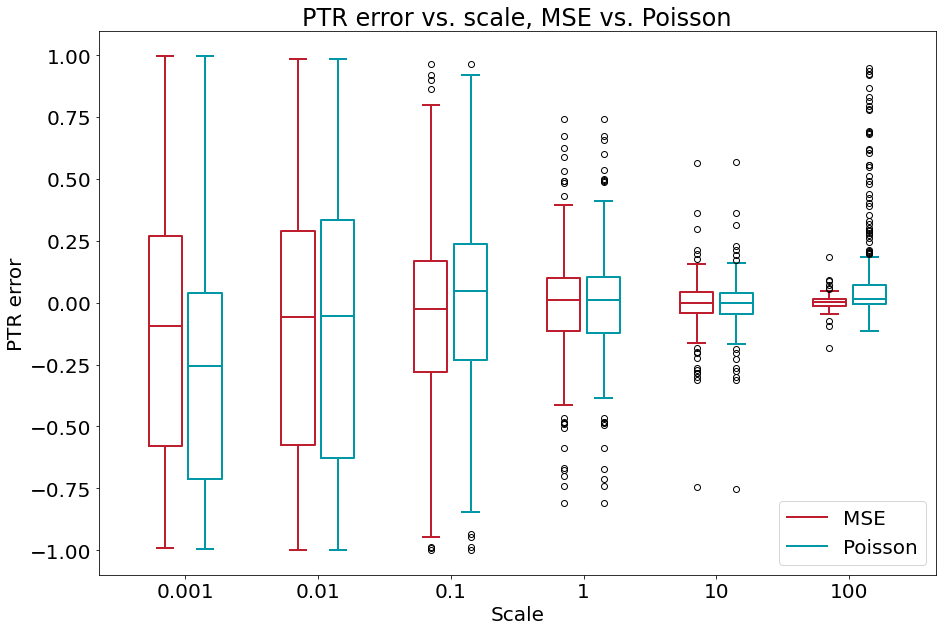

In [8]:
fig = plt.figure(figsize=(15, 10))

# Make data
for_boxplot_mse = results[results["loss_fn"] == losses[0]]
for_boxplot_poisson = results[results["loss_fn"] == losses[1]]
x1 = [for_boxplot_mse[for_boxplot_mse["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_poisson[for_boxplot_poisson["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = plt.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = plt.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
plt.xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
plt.xlabel("Scale")
plt.ylabel("PTR error")
plt.title("PTR error vs. scale, MSE vs. Poisson")

# Change colors for medians
for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
    for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
        for x in b[prop]:
            x.set(color=c, linewidth=2)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["MSE", "Poisson"])
